## Dependecies

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
from albumentations import *
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K

import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model, Model

In [2]:
tf.__version__

'2.2.0-dev20200321'

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Define Parameters

In [4]:
BASE_DIR = "data"

SEED       = 1881
SHAPE      = (224, 224, 3)
BATCH_SIZE = 27

EPOCHS           = 100
WARMUP_EPOCHS    = 5
LR_FINDER_EPOCHS = 2

OVERSAMPLE_RATIO        = 10
TRAIN_TEST_RATIO        = 0.2
CORONA_TRAIN_TEST_RATIO = 0.5

if not os.path.exists("models"):
    os.makedirs("models")
    
# tf2.1 reduce memory alignment(model size) & faster forward propagation
tf.compat.v1.disable_eager_execution()

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

## Load Data Frames

In [5]:
train_csv = pd.read_csv(os.path.join(BASE_DIR, "CheXpert-v1.0-small/train.csv"))
train_csv.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [6]:
metadata = pd.read_csv(os.path.join(BASE_DIR, "covid-chestxray-dataset", "metadata.csv"))
metadata = metadata[metadata["modality"]=="X-ray"]
metadata = metadata[metadata["finding"].isin(["COVID-19", "ARDS", "SARS"])]
metadata = metadata.reset_index(drop=True)
metadata.head()

,Patientid,offset,sex,age,finding,survival,view,modality,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 16
0,2,0.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,PA,X-ray,2020,"Changhua Christian Hospital, Changhua City, Ta...",nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


## Prepare Data Loader

In [7]:
len_classes = len(metadata["finding"].unique())+len(train_csv.columns[5:-1])

In [8]:
class DataGenerator:
    
    """
    data_csv                --> pandas.DataFrame. CheXpert Train CSV
    metadata                --> pandas.DataFrame. covid-chestxray-dataset <https://github.com/ieee8023/covid-chestxray-dataset>
    input_shape             --> TUPLE. Target image size
    batch_size              --> INT. Yielding data size for every iteration
    base_dir                --> STR. Relative path of data directory.
    seed                    --> INT. This makes dataset generator more reproduciable 
    oversample_ratio        --> INT. Oversample minor data by "oversample_ratio" times.
    train_test_ratio        --> FLOAT. How much of data will be used as test set.
    corona_train_test_ratio --> FLOAT. How much of coronavirus data will be used as test set.
    is_train                --> BOOL. Generate Data For Training or Not.
    """
    
    def __init__(self, data_csv, metadata, input_shape, batch_size, base_dir, seed, oversample_ratio, train_test_ratio, corona_train_test_ratio):
        self.DATA_CSV   = data_csv  
        self.METADATA   = metadata
        
        self.SHAPE      = input_shape
        self.BATCH_SIZE = batch_size
        self.SEED       = seed
        
        self.OS_RATIO     = oversample_ratio
        self.TT_RATIO     = train_test_ratio
        self.CORONA_RATIO = corona_train_test_ratio
        
        self.BASE_DIR = base_dir
        
        # Augmentation Probabilities and Limits
        
        '''
        ######### Probs #########
        HorizontalFlip
        CLAHE
        RandomBrightnessContrast
        ShiftScaleRotate

        ########## Limits ##########
        ShiftScaleRotate.shift_limit
        ShiftScaleRotate.scale_limit
        ShiftScaleRotate.rotate_limit
        '''
        
        # Light Augmentation for CheXpert Data
        self.light_aug_probs  = [0.3, 0.5, 0.2, 0.2] 
        self.light_aug_limits = [0.05, 0.05, 5]
        
        # Hard Augmentation for Coronavirus Data
        self.hard_aug_probs  = [0.5, 0.5, 0.8, 0.8]
        self.hard_aug_limits = [0.15, 0.15, 15]
        
        # CheXpert dataset has 3 labels for classes (Positive, Uncertain, Negative). 
        # We dropped data that has "Uncertain" Label to get more reliable results.
        self.DATA_CSV   = self.drop_uncertain_data(self.DATA_CSV) 
        
        # Some data instances just have Uncertain or Negative Samples. We dropped that instances.
        self.DATA_CSV   = self.drop_not_detected_disease_case(self.DATA_CSV)
        self.DATA_CSV   = self.DATA_CSV.reset_index(drop=True)
        
        self.paths_chexpert, self.labels_chexpert = self.get_paths_n_labels(self.DATA_CSV)
        self.paths_corona  , self.labels_corona   = self.get_paths_n_labels_corona(self.METADATA, self.DATA_CSV)
        
        self.paths_corona_train, self.paths_corona_test, self.labels_corona_train, self.labels_corona_test = train_test_split(np.array(self.paths_corona), np.array(self.labels_corona).astype(np.float32), stratify=np.array(self.labels_corona).astype(np.float32).argmax(axis=1), test_size=self.CORONA_RATIO, random_state=self.SEED)
        
        # Oversampling Coronavirus Training Data 
        self.paths_corona_train  = np.vstack([self.paths_corona_train]*self.OS_RATIO)
        self.labels_corona_train = np.vstack([self.labels_corona_train]*self.OS_RATIO)

    def get_gen(self, mode, aug=None):
        if mode=="train":
            all_train_img_paths, all_train_labels = self.split_train_test(get="train")
            x_train, x_val, y_train, y_val = train_test_split(all_train_img_paths, all_train_labels, stratify=all_train_labels.argmax(axis=1), test_size=self.TT_RATIO, random_state=self.SEED)
            train_gen = self.train_data_generator(x_train, y_train, aug=aug) 
            val_gen   = self.train_data_generator(x_val, y_val, aug=False) 
            return train_gen, val_gen, x_train.shape[0], x_val.shape[0]
        
        else:
            return self.split_train_test(get=mode)
    
    # Collect Image Paths and Labels for Coronavirus Dataset
    def get_paths_n_labels_corona(self, metadata, data_csv):
        paths  = []
        labels = []
        
        for f_name in os.listdir(os.path.join(self.BASE_DIR, "covid-chestxray-dataset", "images")):
            get_data_row = metadata[metadata["filename"]==f_name]
            if not get_data_row.empty:
                label = np.zeros((len(metadata["finding"].unique())))
                label_idx = np.where(get_data_row['finding'].values==metadata["finding"].unique())[0][0]
                label[label_idx] = 1
                labels.append(label)

                paths.append(os.path.join(self.BASE_DIR, "covid-chestxray-dataset", "images", f_name))
        
        labels = np.array(labels)
        
        # Add CheXpert labels
        labels = np.concatenate((labels, np.zeros((len(labels), len(data_csv.columns[5:-1])))), axis=1)
        return np.array(paths).reshape((len(paths),1)), np.array(labels).reshape((len(labels), len(self.METADATA["finding"].unique())+len(self.DATA_CSV.columns[5:-1])))
    
    def drop_uncertain_data(self, data_csv):
        # Use set instead of list to remove duplicated row indexes
        to_drop_indexes = set()

        for col in data_csv.columns:
            to_drop_indexes.update(data_csv[data_csv[col]==-1.0].index)

        data_csv = data_csv.drop(list(to_drop_indexes), axis=0)
        data_csv = data_csv.reset_index(drop=True)
        return data_csv 
    
    def drop_not_detected_disease_case(self, data_csv): 
        d = data_csv.iloc[:,5:-1].apply(lambda x: 1 if x.max()!=1 else 0, axis=1)
        to_drop_indexes = d[d.values==1].index
        
        data_csv = data_csv.drop(list(to_drop_indexes), axis=0)
        data_csv = data_csv.reset_index(drop=True)
        return data_csv 
    
    # Collect Image Paths and Labels for CheXpert Dataset
    def get_paths_n_labels(self, data_csv):
        # Fill NaN values with 0
        data_csv = data_csv.fillna(0)
        
        paths  = np.array(self.BASE_DIR + "/" + data_csv["Path"])
        labels = np.array(data_csv.iloc[:,5:-1]).astype(np.float32)
        
        # Add Coronavirus labels
        labels = np.concatenate((np.zeros((len(labels),3)), labels), axis=1)
        return np.array(paths).reshape((len(paths),1)), np.array(labels).reshape((len(labels), len(self.METADATA["finding"].unique())+len(self.DATA_CSV.columns[5:-1])))

    def augmenting(self, img, aug_probs, aug_limits, aug):
        if aug:
            augment = Compose([HorizontalFlip(p=aug_probs[0]),
                               CLAHE(p=aug_probs[1]),
                               RandomBrightnessContrast(p=aug_probs[2]),
                               ShiftScaleRotate(p=aug_probs[3], shift_limit=aug_limits[0], scale_limit=aug_limits[1], rotate_limit=aug_limits[2])])  
        else:
            augment = Compose([])  

        img = augment(image=img)['image']
        return img
    
    def split_train_test(self, get): 
        img_paths, labels = self.paths_chexpert, self.labels_chexpert
        x_train, x_test, y_train, y_test = train_test_split(np.array(img_paths), np.array(labels).astype(np.float32), stratify=np.array(labels).astype(np.float32).argmax(axis=1), test_size=self.TT_RATIO, random_state=self.SEED)
        
        if get=='train':
            x_train_all = np.concatenate((self.paths_corona_train , x_train), axis=0)
            y_train_all = np.concatenate((self.labels_corona_train, y_train), axis=0)
            
            np.random.seed(self.SEED)
            np.random.shuffle(x_train_all)

            np.random.seed(self.SEED)
            np.random.shuffle(y_train_all)
            return x_train_all, y_train_all
        
        elif get=='test_chexpert':
            return x_test, y_test
        
        elif get=='test_corona':
            return self.paths_corona_test, self.labels_corona_test
            
        elif get=='test_all':
            x_test_all = np.concatenate((self.paths_corona_test , x_test), axis=0)
            y_test_all = np.concatenate((self.labels_corona_test, y_test), axis=0)
            
            np.random.seed(self.SEED)
            np.random.shuffle(x_test_all)

            np.random.seed(self.SEED)
            np.random.shuffle(y_test_all)
            return x_test_all, y_test_all
                      
    def train_data_generator(self, t_img_paths, t_labels, aug):
        # Training Image Paths and Training Labels Should have same number.
        assert t_img_paths.shape[0] == t_labels.shape[0]
        
        while True:
            x_batch = np.empty((self.BATCH_SIZE,)+self.SHAPE, dtype=np.float32)
            y_batch = np.empty((self.BATCH_SIZE, len(self.METADATA["finding"].unique())+len(self.DATA_CSV.columns[5:-1])), dtype=np.float32)
            
            # Random batching
            batch = np.random.choice(t_img_paths.shape[0], self.BATCH_SIZE)

            for ix, id_ in enumerate(batch):
                
                # y 
                label = t_labels[id_]
                
                # x
                img_path = t_img_paths[id_][0]
                img = cv2.imread(img_path)
                
                if 1 in label[:3]:
                    img = self.augmenting(img, self.hard_aug_probs, self.hard_aug_limits, aug)
                else:
                    img = self.augmenting(img, self.light_aug_probs, self.light_aug_limits, aug)
                
                # Resize and Normalize Image
                img = cv2.resize(img, self.SHAPE[:2])
                img = np.divide(img, 255)

                # Store the values    
                x_batch[ix] = img
                y_batch[ix] = label

            yield x_batch, y_batch
            
data_generator = DataGenerator(train_csv, metadata, SHAPE, BATCH_SIZE, BASE_DIR, SEED, OVERSAMPLE_RATIO, TRAIN_TEST_RATIO, CORONA_TRAIN_TEST_RATIO)            

## Visualize sample data

[[[0.01568628 0.01568628 0.01568628]
  [0.01960784 0.01960784 0.01960784]
  [0.02745098 0.02745098 0.02745098]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]]

 [[0.02352941 0.02352941 0.02352941]
  [0.02745098 0.02745098 0.02745098]
  [0.02352941 0.02352941 0.02352941]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]]

 [[0.02352941 0.02352941 0.02352941]
  [0.02745098 0.02745098 0.02745098]
  [0.02745098 0.02745098 0.02745098]
  ...
  [0.02745098 0.02745098 0.02745098]
  [0.01568628 0.01568628 0.01568628]
  [0.00392157 0.00392157 0.00392157]]

 ...

 [[0.18039216 0.18039216 0.18039216]
  [0.18039216 0.18039216 0.18039216]
  [0.41960785 0.41960785 0.41960785]
  ...
  [0.13333334 0.13333334 0.13333334]
  [0.13725491 0.13725491 0.13725491]
  [0.15294118 0.15294118 0.15294118]]

 [[0.30588236 0.30588236 0.30588236]
  [0.35686275 0.35686275 0.35686275]


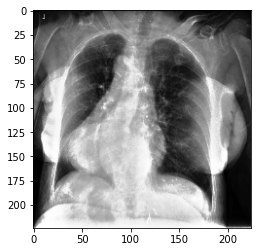

**********
[[[0.13333334 0.13333334 0.13333334]
  [0.14117648 0.14117648 0.14117648]
  [0.13725491 0.13725491 0.13725491]
  ...
  [0.03529412 0.03529412 0.03529412]
  [0.01960784 0.01960784 0.01960784]
  [0.02745098 0.02745098 0.02745098]]

 [[0.13333334 0.13333334 0.13333334]
  [0.13333334 0.13333334 0.13333334]
  [0.1254902  0.1254902  0.1254902 ]
  ...
  [0.04313726 0.04313726 0.04313726]
  [0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]]

 [[0.1254902  0.1254902  0.1254902 ]
  [0.12941177 0.12941177 0.12941177]
  [0.13333334 0.13333334 0.13333334]
  ...
  [0.04313726 0.04313726 0.04313726]
  [0.14117648 0.14117648 0.14117648]
  [0.03137255 0.03137255 0.03137255]]

 ...

 [[0.10588235 0.10588235 0.10588235]
  [0.01176471 0.01176471 0.01176471]
  [0.         0.         0.        ]
  ...
  [0.04705882 0.04705882 0.04705882]
  [0.16470589 0.16470589 0.16470589]
  [0.18039216 0.18039216 0.18039216]]

 [[0.09411765 0.09411765 0.09411765]
  [0.00392157 0.00392157 0

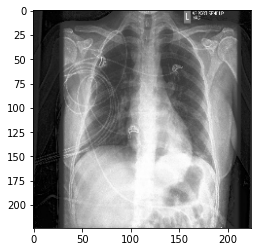

In [9]:
tg, vg, num_train_samples, num_val_samples = data_generator.get_gen(mode="train", aug=True)

for ix, data in enumerate(tg):
    img_batch, label_batch = data
    print(img_batch[0])
    print(img_batch[0].shape)
    print("-"*10)
    print(label_batch[0])
    print(label_batch[0].shape)
    print("-"*10)
    plt.imshow(img_batch[0])
    plt.show()

    if ix==0:
        break

print("*"*10)

for ix, data in enumerate(vg):
    img_batch, label_batch = data
    print(img_batch[0])
    print(img_batch[0].shape)
    print("-"*10)
    print(label_batch[0])
    print(label_batch[0].shape)
    print("-"*10)
    plt.imshow(img_batch[0])
    plt.show()

    if ix==0:
        break

## BreastNet

### Citation
```
M. Togaçar, K.B. Özkurt, B. Ergen et al., BreastNet: A novel ˘
convolutional neural network model through histopathological images for the diagnosis of breast
cancer, Physica A (2019), doi: https://doi.org/10.1016/j.physa.2019.123592.
```

For more information: Please check https://github.com/Goodsea/BreastNet

In [10]:
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

In [11]:
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = SeparableConv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = SeparableConv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [12]:
def create_model(out_neuron_number):
    
    dropRate = 0.5
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(out_neuron_number, activation='sigmoid')(x)
   
    model = Model(init, y)
    return model

In [13]:
model = create_model(len_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Find Optimal Learning Rate

In [14]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

Epoch 1/2
3153/3153 - 1880s - loss: 0.3006 - auc: 0.5943 - val_loss: 0.3690 - val_auc: 0.5587
Epoch 2/2
3153/3153 - 1613s - loss: 0.2715 - auc: 0.6547 - val_loss: 0.4317 - val_auc: 0.5959


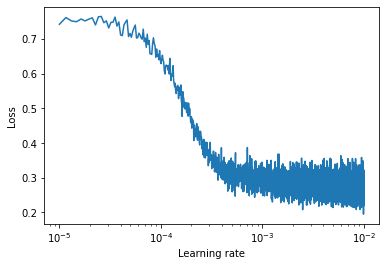

In [15]:
lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-2, 
                     steps_per_epoch=num_train_samples//BATCH_SIZE, 
                     epochs=2)

callbacks = [lr_finder] 

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=[AUC(multi_label=True, name="auc")])

model.fit(tg,
          steps_per_epoch=num_train_samples//BATCH_SIZE,
          epochs=LR_FINDER_EPOCHS,
          verbose=2,
          validation_data=vg,
          validation_steps=num_val_samples//BATCH_SIZE,
          callbacks=callbacks)

lr_finder.plot_loss()

## Warm-up Model with the Optimal Learning Rate

In [16]:
# Warm-up Model
model_ckpt = "models/CORONA_DIAGNOSE_MODEL_warmup.h5"
callbacks = [ModelCheckpoint(model_ckpt, monitor='val_auc', mode='max', verbose=1, save_best_only=True, save_weights_only=False),
             TensorBoard(log_dir=os.path.join("logs",f"fit_warmup",f"{datetime.datetime.now().strftime('Y%m%d-%H%M%S')}"), update_freq='batch')] 

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-4), metrics=[AUC(multi_label=True, name="auc")])

model.fit(tg,
          steps_per_epoch=num_train_samples//BATCH_SIZE,
          epochs=WARMUP_EPOCHS,
          verbose=2,
          validation_data=vg,
          validation_steps=num_val_samples//BATCH_SIZE,
          callbacks=callbacks)

Epoch 1/5

Epoch 00001: val_auc improved from -inf to 0.70478, saving model to models/CORONA_DIAGNOSE_MODEL_warmup.h5
3153/3153 - 1790s - loss: 0.2641 - auc: 0.6795 - val_loss: 0.2582 - val_auc: 0.7048
Epoch 2/5

Epoch 00002: val_auc improved from 0.70478 to 0.71299, saving model to models/CORONA_DIAGNOSE_MODEL_warmup.h5
3153/3153 - 1759s - loss: 0.2618 - auc: 0.6817 - val_loss: 0.2573 - val_auc: 0.7130
Epoch 3/5

Epoch 00003: val_auc improved from 0.71299 to 0.74160, saving model to models/CORONA_DIAGNOSE_MODEL_warmup.h5
3153/3153 - 1739s - loss: 0.2595 - auc: 0.6983 - val_loss: 0.2556 - val_auc: 0.7416
Epoch 4/5

Epoch 00004: val_auc did not improve from 0.74160
3153/3153 - 1767s - loss: 0.2583 - auc: 0.7079 - val_loss: 0.2554 - val_auc: 0.7212
Epoch 5/5

Epoch 00005: val_auc improved from 0.74160 to 0.74476, saving model to models/CORONA_DIAGNOSE_MODEL_warmup.h5
3153/3153 - 1699s - loss: 0.2572 - auc: 0.7152 - val_loss: 0.2560 - val_auc: 0.7448


## Training with Learning Rate Scheduler

In [17]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [18]:
model.load_weights("models/CORONA_DIAGNOSE_MODEL_warmup.h5")

schedule = SGDRScheduler(min_lr=1e-5,
                         max_lr=1e-2,
                         steps_per_epoch=num_train_samples//BATCH_SIZE,
                         lr_decay=0.7,
                         cycle_length=5,
                         mult_factor=1.5)

model_ckpt = "models/CORONA_DIAGNOSE_MODEL.h5"
callbacks = [ModelCheckpoint(model_ckpt, monitor='val_auc', mode='max', verbose=1, save_best_only=True, save_weights_only=False),
             EarlyStopping(monitor='val_auc', patience=10, verbose=1, mode='max', restore_best_weights=True),
             TensorBoard(log_dir=os.path.join("logs",f"fit",f"{datetime.datetime.now().strftime('Y%m%d-%H%M%S')}"), update_freq='batch'),
             schedule] 

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=[AUC(multi_label=True, name="auc")])

model.fit(tg,
          steps_per_epoch=num_train_samples//BATCH_SIZE,
          epochs=EPOCHS,
          verbose=2,
          validation_data=vg,
          validation_steps=num_val_samples//BATCH_SIZE,
          callbacks=callbacks)

Epoch 1/100

Epoch 00001: val_auc improved from -inf to 0.71627, saving model to models/CORONA_DIAGNOSE_MODEL.h5
3153/3153 - 1727s - loss: 0.2671 - auc: 0.6713 - val_loss: 0.2722 - val_auc: 0.7163
Epoch 2/100

Epoch 00002: val_auc improved from 0.71627 to 0.72772, saving model to models/CORONA_DIAGNOSE_MODEL.h5
3153/3153 - 1720s - loss: 0.2623 - auc: 0.7066 - val_loss: 0.2663 - val_auc: 0.7277
Epoch 3/100

Epoch 00003: val_auc improved from 0.72772 to 0.73338, saving model to models/CORONA_DIAGNOSE_MODEL.h5
3153/3153 - 1732s - loss: 0.2580 - auc: 0.7163 - val_loss: 0.2770 - val_auc: 0.7334
Epoch 4/100

Epoch 00004: val_auc improved from 0.73338 to 0.75827, saving model to models/CORONA_DIAGNOSE_MODEL.h5
3153/3153 - 1822s - loss: 0.2550 - auc: 0.7331 - val_loss: 0.2492 - val_auc: 0.7583
Epoch 5/100

Epoch 00005: val_auc improved from 0.75827 to 0.76251, saving model to models/CORONA_DIAGNOSE_MODEL.h5
3153/3153 - 1824s - loss: 0.2530 - auc: 0.7393 - val_loss: 0.2481 - val_auc: 0.7625
Epo

W0324 07:11:44.354183  3864 callbacks.py:305] Method (on_train_batch_end) is slow compared to the batch update (0.508448). Check your callbacks.



Epoch 00022: val_auc did not improve from 0.79009
3153/3153 - 1768s - loss: 0.2408 - auc: 0.7746 - val_loss: 0.2381 - val_auc: 0.7829
Epoch 23/100

Epoch 00023: val_auc did not improve from 0.79009
3153/3153 - 1777s - loss: 0.2404 - auc: 0.7845 - val_loss: 0.2352 - val_auc: 0.7306
Epoch 24/100

Epoch 00024: val_auc improved from 0.79009 to 0.79566, saving model to models/CORONA_DIAGNOSE_MODEL.h5
3153/3153 - 1776s - loss: 0.2397 - auc: 0.7835 - val_loss: 0.2358 - val_auc: 0.7957
Epoch 25/100

Epoch 00025: val_auc did not improve from 0.79566
3153/3153 - 1764s - loss: 0.2403 - auc: 0.7850 - val_loss: 0.2357 - val_auc: 0.7951
Epoch 26/100

Epoch 00026: val_auc did not improve from 0.79566
3153/3153 - 1780s - loss: 0.2431 - auc: 0.7773 - val_loss: 0.2546 - val_auc: 0.7743
Epoch 27/100

Epoch 00027: val_auc did not improve from 0.79566
3153/3153 - 1806s - loss: 0.2435 - auc: 0.7786 - val_loss: 0.2695 - val_auc: 0.7621
Epoch 28/100

Epoch 00028: val_auc did not improve from 0.79566
3153/315

## Test Phase

In [19]:
# Apply Threshold predictions by maximum value in array
def threshold_arr(array):
    new_arr = []
    for ix, val in enumerate(array):
        loc = np.array(val).argmax(axis=0)
        k = list(np.zeros((len(val)), dtype=np.float32))
        k[loc]=1
        new_arr.append(k)
        
    return np.array(new_arr, dtype=np.float32)

In [20]:
model = load_model("models/CORONA_DIAGNOSE_MODEL.h5")

## Test Model with just Seperated Coronavirus Image Data

In [21]:
gen = data_generator.get_gen(mode="test_corona")

x_test = np.zeros((len(gen[0]),)+SHAPE, dtype=np.float32)
y_test = np.zeros((len(gen[1]), len_classes), dtype=np.float32)

for ix, path in tqdm(enumerate(gen[0])):
    img = cv2.imread(path[0])
    img = cv2.resize(img, SHAPE[:2])
    img = np.divide(img,255)

    label = gen[1][ix]

    x_test[ix] = img
    y_test[ix] = label

60it [00:02, 23.84it/s]


In [22]:
score = model.evaluate(x_test, y_test, verbose=0)
print(score)

[0.09516207178433736, 0.1618239]


<b>We used <em>average='samples'</em> for multi-label classification.</b>

In [23]:
y_preds = threshold_arr(model.predict(x_test, verbose=0))
results = precision_recall_fscore_support(y_test, y_preds, average='samples')
acc = accuracy_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_preds, average='samples')

print("ROC_AUC: {}, Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(roc_auc, acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y_test, y_preds))

ROC_AUC: 0.9377777777777777, Accuracy: 0.8833333333333333, F1_Score: 0.8833333333333333, Precision: 0.8833333333333333, Recall: 0.8833333333333333




C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.94      0.94      0.94        53
           1       0.00      0.00      0.00         2
           2       0.75      0.60      0.67         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        60
   macro avg       0.11   

## Test Model with just Seperated Test (Coronavirus + CheXpert) Image Data

In [24]:
gen = data_generator.get_gen(mode="test_all")

x_test = np.zeros((len(gen[0]),)+SHAPE, dtype=np.float32)
y_test = np.zeros((len(gen[1]), len_classes), dtype=np.float32)

for ix, path in tqdm(enumerate(gen[0])):
    img = cv2.imread(path[0])
    img = cv2.resize(img, SHAPE[:2])
    img = np.divide(img,255)

    label = gen[1][ix]

    x_test[ix] = img
    y_test[ix] = label

26517it [13:12, 15.96it/s]


In [25]:
y_preds = threshold_arr(model.predict(x_test, verbose=0))

In [26]:
results = precision_recall_fscore_support(y_test, y_preds, average='samples')
acc = accuracy_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_preds, average='samples')

print("ROC_AUC: {}, Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(roc_auc, acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y_test, y_preds))

ROC_AUC: 0.6711264915982644, Accuracy: 0.20100313006750387, F1_Score: 0.43764575106355846, Precision: 0.625523249236339, Recall: 0.3682229908217011




C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.91      0.94      0.93        53
           1       0.00      0.00      0.00         2
           2       0.75      0.60      0.67         5
           3       0.51      0.73      0.60      4454
           4       0.00      0.00      0.00      1421
           5       0.58      0.19      0.28      3576
           6       0.52      0.18      0.27     10643
           7       0.00      0.00      0.00      1133
           8       0.64      0.28      0.39      7129
           9       0.00      0.00      0.00      1720
          10       0.00      0.00      0.00       757
          11       0.37      0.03      0.05      4751
          12       0.57      0.19      0.28      2989
          13       0.74      0.71      0.73     11163
          14       0.00      0.00      0.00       404
          15       0.00      0.00      0.00      1209

   micro avg       0.63      0.32      0.43     51409
   macro avg       0.35   

In [27]:
del x_test

## Convert Results to Binary to Measure Sensitivity of SARS-CoV-2

In [28]:
covid_ord = np.where(metadata["finding"].unique()=='COVID-19')[0][0]

In [29]:
bin_labels = []
for pred in y_test:
    if pred.argmax() == covid_ord:
        binary_label = 1
    else:
        binary_label = 0
    bin_labels.append(binary_label)
    
bin_preds = []
for pred in y_preds:
    if pred.argmax() == covid_ord:
        binary_label = 1
    else:
        binary_label = 0
    bin_preds.append(binary_label)

ROC_AUC: 0.971603645251078, Accuracy: 0.9996983067466154, F1_Score: 0.9259259259259259, Precision: 0.9090909090909091, Recall: 0.9433962264150944


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26464
           1       0.91      0.94      0.93        53

    accuracy                           1.00     26517
   macro avg       0.95      0.97      0.96     26517
weighted avg       1.00      1.00      1.00     26517





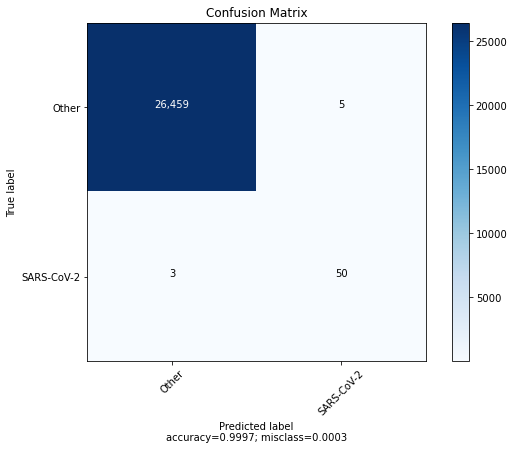

In [30]:
from confusion_matrix import plot_confusion_matrix

results = precision_recall_fscore_support(bin_labels, bin_preds, average='binary')
acc = accuracy_score(bin_labels, bin_preds)
roc_auc = roc_auc_score(bin_labels, bin_preds)

print("ROC_AUC: {}, Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(roc_auc, acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(bin_labels, bin_preds))
print("\n")
cnf_matrix = confusion_matrix(bin_labels, bin_preds)

plot_confusion_matrix(cm           = cnf_matrix, 
                      desc         = "Binary SARS-CoV-2 Classification",
                      normalize    = False,
                      target_names = ['Other','SARS-CoV-2'],
                      title        = "Confusion Matrix")